In [69]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import math
from collections import OrderedDict
import residuals as r

%matplotlib inline
import matplotlib.gridspec as gridspec
plt.rcParams['font.family']='serif'

micro = 10**(6)

from matplotlib import ticker
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [70]:
def weighted_stddev(values, errors):
    '''
    Return the weighted average and standard deviation.

    '''
    weights = 1. / ((errors)**2)
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return (math.sqrt(variance))

def magnitude(x):
    '''
    Return the magnitude of a variable
    '''
    var = float(x)
    return int(math.floor(math.log10(var)))

ValueError: 'vertices' must be a 2D list or array with shape Nx2

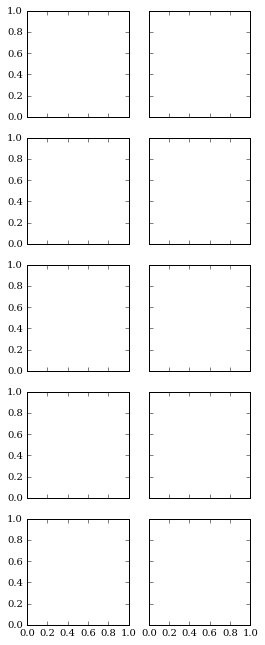

In [51]:
fig, axes = plt.subplots(figsize=(4,11), nrows=5, ncols=2, sharex=True, sharey=True)
X = np.linspace(0,10,10)
C, S = np.linspace(0,1.0,10), np.sin(X)

cm=plt.cm.plasma
# colors=[colormap(ii) for ii in range(0,10)]

z=np.linspace(0,1.0,10)

#for each subplot:
lines=zip(X, C)
lines=LineCollection(lines, array=z, cmap=cm, linewidth=1.0)
# axes[0,0].plot(X, C + ii, c=z, linewidth=1.0, linestyle="-")
axes[0,0].add_collection(lines)
axes[0,1].plot(X, C, linewidth=1.0, linestyle="-")
axes[1,0].plot(X, C, linewidth=1.0, linestyle="-")
axes[1,1].plot(X, C, linewidth=1.0, linestyle="-")
axes[2,0].plot(X, C, linewidth=1.0, linestyle="-")
axes[2,1].plot(X, C, linewidth=1.0, linestyle="-")
axes[3,0].plot(X, C, linewidth=1.0, linestyle="-")
axes[3,1].plot(X, C, linewidth=1.0, linestyle="-")
axes[4,0].plot(X, C, linewidth=1.0, linestyle="-")
axes[4,1].plot(X, C, linewidth=1.0, linestyle="-")

# fig.set_aspect('equal')

fig.colorbar(lines)

plt.subplots_adjust(wspace=0,hspace=0)
plt.show()

#trying to fix the overstacked numbers
# from matplotlib.ticker import MaxNLocator
# axes[1,1].yaxis.set_major_locator(MaxNLocator(prune='lower'))
# axes[1,1].xaxis.set_major_locator(MaxNLocator(prune='lower'))

In [28]:
#Fun with dictionaries
d=OrderedDict()
print d
d['dict1']=OrderedDict()
print d
d['dict1']['innerkey']='value'
print d

#To access the right dictionary values: http://stackoverflow.com/questions/21507956/plotting-dictionaries-within-a-dictionary-in-myplotlib-python

OrderedDict()
OrderedDict([('dict1', OrderedDict())])
OrderedDict([('dict1', OrderedDict([('innerkey', 'value')]))])


In [122]:
def make_arrays(psrname, MJDint):
    condition_lower=MJDint
    condition_upper=MJDint+0.99
    
    jitter_ratios = OrderedDict()
    corr_coefs = OrderedDict()
    file_names = []
    for elem in ['320','160','80', '40', '20', 'NT']:
        #Define sigma_all (or std_all) as entire observation period
        x=r.read_residuals(filename="/nimrod1/eschwab/residuals/%s_resid_%s_%sF8.tmp" %(psrname, MJDint, elem))
        
        condition = (x.bary_TOA > condition_lower) & (x.bary_TOA < condition_upper)
        Resid_all = x.prefit_sec[condition]
        Errors_all = x.uncertainty[condition]
        std_all = weighted_stddev(Resid_all, Errors_all)

        ##============

        #Define sigma_dump (or std_all) as individual dumps within observation period

        #This isolates the numbers for the different dump times
        rounded = np.round(np.array([x.bary_TOA[condition] - 0.00005]), 4)
        dumptimes=[]
        for i in rounded.tolist()[0]: 
            if i not in dumptimes:
                dumptimes.append(i)

        #This calculates a list of sigma_dump values and averages those
        str_dump_devs=[]
        for i in dumptimes:
            timeindex = (rounded == i)[0]
            Resid = Resid_all[timeindex]
            Errors = Errors_all[timeindex]
            single_std_dump = weighted_stddev(Resid, Errors)
            str_dump_devs.append(single_std_dump)

        #to convert str_dump_devs out of scientific notation
        dump_devs=[]
        for i in str_dump_devs:
            dump_devs.append('{0:.20f}'.format(i))

        #prints the magnitude of each sigma_dump in a list and finds average magnitude
        magarray=[]
        for i in dump_devs:
            magarray.append(magnitude(i))
        averagemag = round(np.mean(magarray))

        arg=averagemag+1.5
        makemask = np.ma.masked_where(np.array(magarray) > arg, np.array(magarray))

        std_dump=np.mean(str_dump_devs)
        masked_std_dump = np.mean(np.ma.masked_where(np.ma.getmask(makemask), str_dump_devs))

        #Setup jitter ratio
        ratio = std_all / std_dump
        masked_ratio = float(std_all / masked_std_dump)
        jitter_ratios[elem] = masked_ratio

        ##============

        #Print out the correlation coefficient also, to allow for easy reference

        #Creating the matrix of the data and transposing it to correct format
        data = []
        data_errors = []
        for i in dumptimes[1:]: #the first set of resids needs to be skipped in J1713, but not sure for all of them?
            timeindex = (rounded == i)[0]
            Resids = Resid_all[timeindex]
            Errors = Errors_all[timeindex]
            data.append(Resids)
            data_errors.append(Errors)

        data = map(list, zip(*data)) #transposing the matrix, supposedly unnecessary if rowvar=0 in corr but gives errors

        #Using the Weighted Correlation Coefficient from wikipedia
        #https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient#Weighted_correlation_coefficient
        # I added weights by creating a weighted value to multiply each data element by
        #The weighted values are normalized by dividing each value by the sum of all weights

        data_weights = 1. / (np.array(data_errors)**2)
        data_weights = map(list, zip(*(data_weights.tolist())))

        #data_weights is a matrix of all the weights

        norm_weights = []
        for i in data_weights:
            norm_weights.append([j/sum(i) for j in i])

        weighted_data = []
        for i,j in zip(data, norm_weights):
            weighted_data.append([a*b for a,b in zip(i,j)])

        #Correlating! 
        corr = np.corrcoef(data)
        weighted_corr = np.corrcoef(weighted_data)

        unique_corrs = []
        #Averaging the correlation
        for i in range(len(corr)):
            unique_corrs.append(corr[i][i+1:]) #because numpy array, double index necessay
        unique_corrs  = [val for sublist in unique_corrs for val in sublist]
        final_coefficient = np.average(unique_corrs)

        unique_weighted_corrs = []
        #Averaging the correlation
        for i in range(len(weighted_corr)):
            unique_weighted_corrs.append(weighted_corr[i][i+1:]) #because numpy array, double index necessay
        unique_weighted_corrs  = [val for sublist in unique_weighted_corrs for val in sublist]
        final_weighted_coefficient = np.average(unique_weighted_corrs)
        
        corr_coefs[elem] = final_coefficient

    return jitter_ratios, corr_coefs

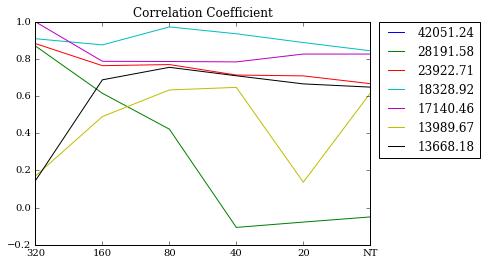

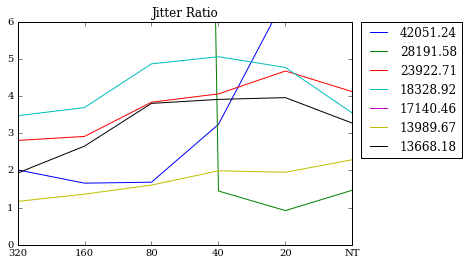

In [136]:
days=(56201, 56577, 57305, 57302, 56458, 56380, 57319, 56934, 57041)
SNR=(42051.24, 28191.58, 23922.71, 18328.92, 17335.41, 17140.46, 
     13989.67, 13668.18, 13117.22)
days=(56201, 56577, 57305, 57302, 56380, 57319, 57041)
SNR=(42051.24, 28191.58, 23922.71, 18328.92, 17140.46, 13989.67, 13668.18)# 13117.22)

plotjitter=OrderedDict()
plotcorr=OrderedDict()
for ii,jj in zip(days, SNR):
    arrays=make_arrays('J1713+0747', ii) #arrays[0] is jitter, arrays[1] is corr
    plotjitter[jj]=arrays[0]
    plotcorr[jj]=arrays[1]

plt.figure()
plt.title('Correlation Coefficient')
for SNRval, data_dict in plotcorr.iteritems():
    x=range(len(data_dict))
    y=data_dict.values()
    plt.plot(x,y, label=str(SNRval))
    plt.xticks(range(len(data_dict)), data_dict.keys())
    plt.legend(bbox_to_anchor=(1, 1.04), loc=2, borderaxespad=0.75)
    
plt.figure()
plt.title('Jitter Ratio')
for SNRval, data_dict in plotjitter.iteritems():
    x=range(len(data_dict))
    y=data_dict.values()
    plt.plot(x,y, label=str(SNRval))
    plt.xticks(range(len(data_dict)), data_dict.keys())
    plt.ylim(0,6)
    plt.legend(bbox_to_anchor=(1, 1.04), loc=2, borderaxespad=0.75)

In [115]:
x=r.read_residuals(filename="/nimrod1/eschwab/residuals/J1713+0747_resid_56380_80F8.tmp")
print x.bary_freq

[ 1728.86640269  1654.88136703  1561.34284597  1473.8128752   1389.08565873
  1298.70093783  1210.39795803  1728.75143557  1654.75736705  1561.246796
  1473.99878494  1388.8836599   1298.71388605  1211.02096466  1728.64049612
  1654.82341483  1561.24180374  1474.26781802  1388.97668142  1298.64993644
  1210.40798636  1728.41152417  1654.63435609  1561.41184648  1474.41186116
  1389.14867564  1298.64091445  1210.79492794  1728.7564812   1654.88141939
  1560.85697231  1474.41187283  1389.08570268  1298.66191905  1210.45402184
  1728.63553259  1654.75741944  1561.70786849  1474.41188451  1388.97268574
  1298.77398136  1210.99500408  1728.87246535  1654.88144565  1561.18790256
  1474.41189623  1388.86076775  1298.89287816  1210.65104726  1728.86649856
  1654.8814588   1561.23197944  1474.41190794  1388.99272622  1298.66194998
  1210.51007718  1728.44955372  1654.7574589   1561.6408941   1474.41191967
  1389.08574682  1298.58494048  1210.54304317  1728.8615215   1655.00537623
  1561.6279685